In [ ]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
# HIDDEN
tips = sns.load_dataset('tips')
tips['pcttip'] = tips['tip'] / tips['total_bill'] * 100

In [5]:
# HIDDEN
def mse_loss(theta, y_vals):
    return np.mean((y_vals - theta) ** 2)

def abs_loss(theta, y_vals):
    return np.mean(np.abs(y_vals - theta))

In [6]:
# HIDDEN
def compare_mse_abs(thetas, y_vals, xlims, figsize=(10, 7), cols=3):
    if not isinstance(y_vals, np.ndarray):
        y_vals = np.array(y_vals)
    rows = int(np.ceil(len(thetas) / cols))
    plt.figure(figsize=figsize)
    for i, theta in enumerate(thetas):
        ax = plt.subplot(rows, cols, i + 1)
        sns.rugplot(y_vals, height=0.1, ax=ax)
        plt.axvline(theta, linestyle='--',
                    label=rf'$ \theta = {theta} $')
        plt.title(f'MSE = {mse_loss(theta, y_vals):.2f}\n'
                  f'MAE = {abs_loss(theta, y_vals):.2f}')
        plt.xlim(*xlims)
        plt.yticks([])
        plt.legend()
    plt.tight_layout()

## Absolute and Huber Loss

To fit a model, we select a loss function and select the model parameters that minimize the loss. In the previous section, we introduced the mean squared error (MSE) loss function:

$$
\begin{aligned}
L(\theta, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - \theta)^2\\
\end{aligned}
$$

We used a constant model that predicts the same number $ \theta $ for all entries in the dataset. When we fit this model using the MSE loss, we found that $ \hat{\theta} = \text{mean} (\textbf{y}) $. On the tips dataset, we found that a fitted constant model will predict $ 16.08\% $ since $ 16.08\% $ is the mean of the tip percents.

In this section, we introduce two new loss functions, the **mean absolute error** loss function and the **Huber** loss function.

### Mean Absolute Error

Now, we will keep our model the same but switch to a different loss function: the mean absolute error (MAE). Instead taking the squared difference for each point and our prediction, this loss function takes the absolute difference:

$$
\begin{aligned}
L(\theta, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n} |y_i - \theta| \\
\end{aligned}
$$

### Comparing MSE and MAE

To get a better sense of how the MSE and MAE compare, let's compare their losses on different datasets. First, we'll use our dataset of one point: $ \textbf{y} = [14] $.

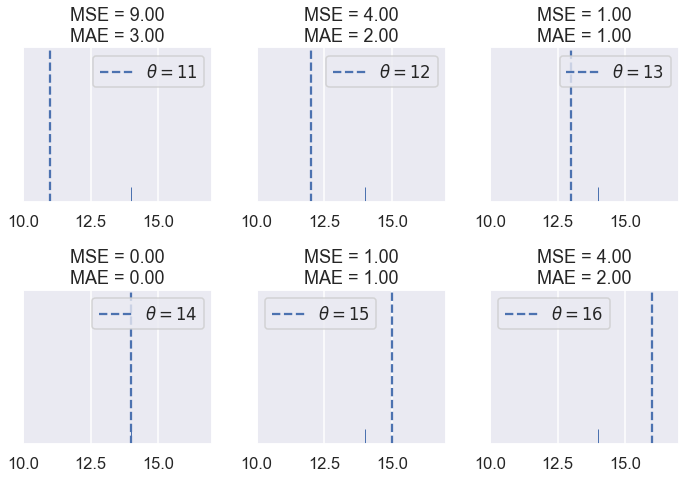

In [7]:
# HIDDEN
compare_mse_abs(thetas=[11, 12, 13, 14, 15, 16],
                y_vals=[14], xlims=(10, 17))

We see that the MSE is usually higher than the MAE since the error is squared. Let's see what happens when have five points: $ \textbf{y} = [ 12.1, 12.8, 14.9, 16.3, 17.2 ] $

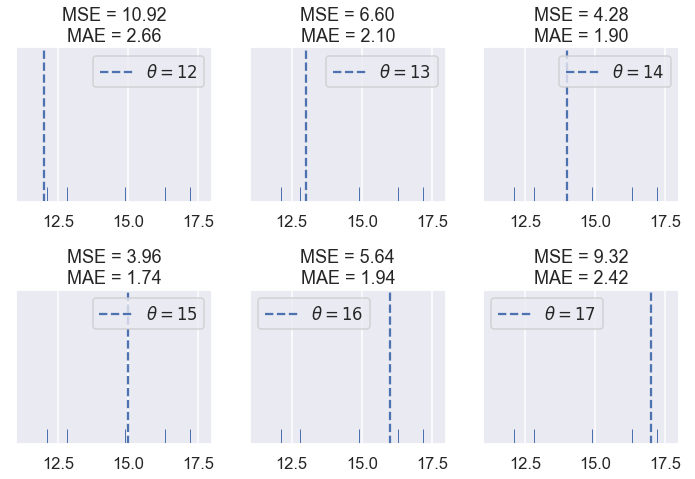

In [8]:
# HIDDEN
compare_mse_abs(thetas=[12, 13, 14, 15, 16, 17],
                y_vals=[12.1, 12.8, 14.9, 16.3, 17.2],
                xlims=(11, 18))

Remember that the actual loss values themselves are not very interesting to us; they are only useful for comparing different values of $ \theta $. Once we choose a loss function, we will look for $ \hat{\theta} $, the $ \theta $ that produces the least loss. Thus, we are interested in whether the loss functions produce different $ \hat{\theta} $.

So far, the two loss functions seem to agree on $ \hat{\theta} $. If we look a bit closer, however, we will start to see some differences. We first take the losses and plot them against $ \theta $ for each of the six $ \theta $ values we tried.

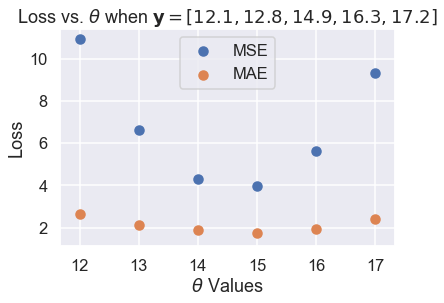

In [9]:
# HIDDEN
thetas = np.array([12, 13, 14, 15, 16, 17])
y_vals = np.array([12.1, 12.8, 14.9, 16.3, 17.2])
mse_losses = [mse_loss(theta, y_vals) for theta in thetas]
abs_losses = [abs_loss(theta, y_vals) for theta in thetas]

plt.scatter(thetas, mse_losses, label='MSE')
plt.scatter(thetas, abs_losses, label='MAE')
plt.title(r'Loss vs. $ \theta $ when $ \bf{y}$$= [ 12.1, 12.8, 14.9, 16.3, 17.2 ] $')
plt.xlabel(r'$ \theta $ Values')
plt.ylabel('Loss')
plt.legend();

Then, we compute more values of $ \theta $ so that the curve is smooth:

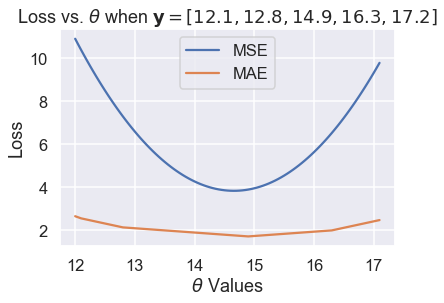

In [10]:
# HIDDEN
thetas = np.arange(12, 17.1, 0.05)
y_vals = np.array([12.1, 12.8, 14.9, 16.3, 17.2])
mse_losses = [mse_loss(theta, y_vals) for theta in thetas]
abs_losses = [abs_loss(theta, y_vals) for theta in thetas]

plt.plot(thetas, mse_losses, label='MSE')
plt.plot(thetas, abs_losses, label='MAE')
plt.title(r'Loss vs. $ \theta $ when $ \bf{y}$$ = [ 12.1, 12.8, 14.9, 16.3, 17.2 ] $')
plt.xlabel(r'$ \theta $ Values')
plt.ylabel('Loss')
plt.legend();

Then, we zoom into the region between 1.5 and 5 on the y-axis to see the difference in minima more clearly. We've marked the minima with dotted lines.

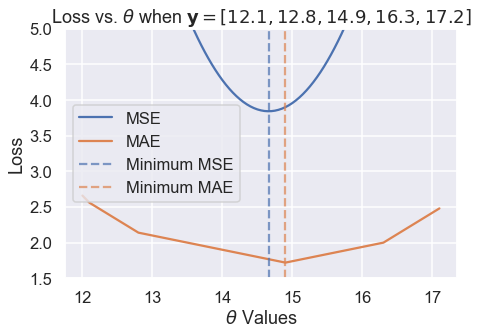

In [25]:
# HIDDEN
thetas = np.arange(12, 17.1, 0.05)
y_vals = np.array([12.1, 12.8, 14.9, 16.3, 17.2])
mse_losses = [mse_loss(theta, y_vals) for theta in thetas]
abs_losses = [abs_loss(theta, y_vals) for theta in thetas]

plt.figure(figsize=(7, 5))
plt.plot(thetas, mse_losses, label='MSE')
plt.plot(thetas, abs_losses, label='MAE')
plt.axvline(np.mean(y_vals), c=sns.color_palette()[0], linestyle='--',
            alpha=0.7, label='Minimum MSE')
plt.axvline(np.median(y_vals), c=sns.color_palette()[1], linestyle='--',
            alpha=0.7, label='Minimum MAE')


plt.title(r'Loss vs. $ \theta $ when $ \bf{y}$$ = [ 12.1, 12.8, 14.9, 16.3, 17.2 ] $')
plt.xlabel(r'$ \theta $ Values')
plt.ylabel('Loss')
plt.ylim(1.5, 5)
plt.legend()
plt.tight_layout();

We've found empirically that the MSE and MAE can produce different $ \hat{\theta} $ for the same dataset. A closer analysis reveals when they will differ and more importantly, why they differ.

### Outliers

One difference that we can see in the plots of loss vs. $ \theta $ above lies in the shape of the loss curves. Plotting the MSE results in a parabolic curve resulting from the squared term in the loss function.

Plotting the MAE, on the other hand, results in what looks like a connected series of lines. This makes sense when we consider that the absolute value function is linear, so taking the average of many absolute value functions should produce a semi-linear function.

Since the MSE has a squared error term, it will be more sensitive to outliers. If $ \theta = 10 $ and a point lies at 110, that point's error term for MSE will be $ (10 - 110)^2 = 10000 $ whereas in the MAE, that point's error term will be $ |10 - 110| = 100 $. We can illustrate this by taking a set of three points $ \textbf{y} = [ 12, 13, 14 ] $ and plotting the loss vs. $ \theta $ curves for MSE and MAE.

Use the slider below to move the third point further away from the rest of the data and observe what happens to the loss curves. (We've scaled the curves to keep both in view since the MSE has larger values than the MAE.)

In [12]:
# HIDDEN
def compare_mse_abs_curves(y3=14):
    thetas = np.arange(11.5, 26.5, 0.1)
    y_vals = np.array([12, 13, y3])
    
    mse_losses = [mse_loss(theta, y_vals) for theta in thetas]
    abs_losses = [abs_loss(theta, y_vals) for theta in thetas]
    mse_abs_diff = min(mse_losses) - min(abs_losses)
    mse_losses = [loss - mse_abs_diff for loss in mse_losses]
    
    plt.figure(figsize=(9, 2))
    
    ax = plt.subplot(121)
    sns.rugplot(y_vals, height=0.3, ax=ax)
    plt.xlim(11.5, 26.5)
    plt.xlabel('Points')
    
    ax = plt.subplot(122)
    plt.plot(thetas, mse_losses, label='MSE')
    plt.plot(thetas, abs_losses, label='MAE')
    plt.xlim(11.5, 26.5)
    plt.ylim(min(abs_losses) - 1, min(abs_losses) + 10)
    plt.xlabel(r'$ \theta $')
    plt.ylabel('Loss')
    plt.legend()

In [13]:
# HIDDEN
interact(compare_mse_abs_curves, y3=(14, 25));

interactive(children=(IntSlider(value=14, description='y3', max=25, min=14), Output()), _dom_classes=('widget-interact',))

We've shown the curves for $ y_3 = 14 $ and $ y_3 = 25 $ below.

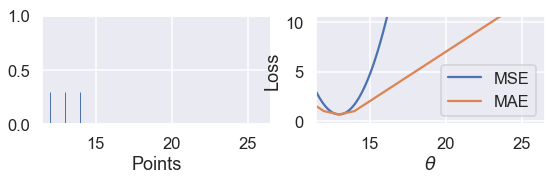

In [14]:
# HIDDEN
compare_mse_abs_curves(y3=14)

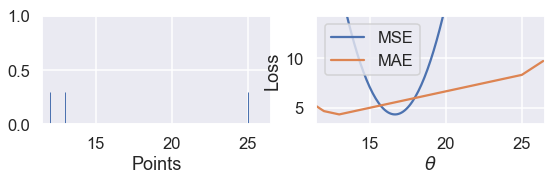

In [15]:
# HIDDEN
compare_mse_abs_curves(y3=25)

As we move the point further away from the rest of the data, the MSE curve moves with it. When $ y_3 = 14 $, both MSE and MAE have $ \hat{\theta} = 13 $. However, when $ y_3 = 25 $, the MSE loss produces $ \hat{\theta} = 16.7 $ while the MAE produces $ \hat{\theta} = 13 $, unchanged from before.

### Minimizing the MAE

Now that we have a qualitative sense of how the MSE and MAE differ, we can minimize the MAE to make this difference more precise. As before, we will take the derivative of the loss function with respect to $ \theta $ and set it equal to zero.

This time, however, we have to deal with the fact that the absolute function is not always differentiable. When $ x > 0 $, $ \frac{\partial}{\partial x} |x| = 1 $. When $ x < 0 $, $ \frac{\partial}{\partial x} |x| = -1 $. Although $ |x| $ is not technicaly differentiable at $ x = 0 $, we will set $ \frac{\partial}{\partial x} |x| = 0 $ so that the equations are easier to work with.

Recall that the equation for the MAE is:

$$
\begin{aligned}
L(\theta, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n}|y_i - \theta|\\
&= \frac{1}{n} \left( \sum_{y_i < \theta}|y_i - \theta| + \sum_{y_i = \theta}|y_i - \theta| + \sum_{y_i > \theta}|y_i - \theta| \right)\\
\end{aligned}
$$

In the line above, we've split up the summation into three separate summations: one that has one term for each $ y_i < \theta $, one for $ y_i = \theta $, and one for $ y_i > \theta $. Why make the summation seemingly more complicated? If we know that $ y_i < \theta $ we also know that $ |y_i - \theta| < 0 $ and thus $ \frac{\partial}{\partial \theta} |y_i - \theta| = -1 $ from before. A similar logic holds for each term above to make taking the derivative much easier.

Now, we take the derivative with respect to $ \theta $ and set it equal to zero:

$$
\begin{aligned}
\frac{1}{n} \left( \sum_{y_i < \theta}(-1) + \sum_{y_i = \theta}(0) + \sum_{y_i > \theta}(1) \right) &= 0 \\
\sum_{y_i < \theta}(-1) + \sum_{y_i > \theta}(1) &= 0 \\
-\sum_{y_i < \theta}(1) + \sum_{y_i > \theta}(1) &= 0 \\
\sum_{y_i < \theta}(1) &= \sum_{y_i > \theta}(1) \\
\end{aligned}
$$

What does the result above mean? On the left hand side, we have one term for each data point less than $ \theta $. On the right, we have one for each data point greater than $ \theta $. Then, in order to satisfy the equation we need to pick a value for $ \theta $ that has the same number of smaller and larger points. This is the definition for the *median* of a set of numbers. Thus, the minimizing value of $ \theta $ for the MAE is $ \hat \theta = \text{median} (\textbf{y}) $.

When we have an odd number of points, the median is simply the middle point when the points are arranged in sorted order. We can see that in the example below with five points, the loss is minimized when $ \theta $ lies at the median:

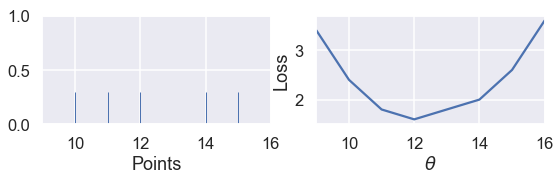

In [16]:
# HIDDEN
def points_and_loss(y_vals, xlim, loss_fn=abs_loss):
    thetas = np.arange(xlim[0], xlim[1] + 0.01, 0.05)
    abs_losses = [loss_fn(theta, y_vals) for theta in thetas]
    
    plt.figure(figsize=(9, 2))
    
    ax = plt.subplot(121)
    sns.rugplot(y_vals, height=0.3, ax=ax)
    plt.xlim(*xlim)
    plt.xlabel('Points')
    
    ax = plt.subplot(122)
    plt.plot(thetas, abs_losses)
    plt.xlim(*xlim)
    plt.xlabel(r'$ \theta $')
    plt.ylabel('Loss')
points_and_loss(np.array([10, 11, 12, 14, 15]), (9, 16))

However, when we have an even number of points, the loss is minimized when $ \theta $ is any value in between the two central points.

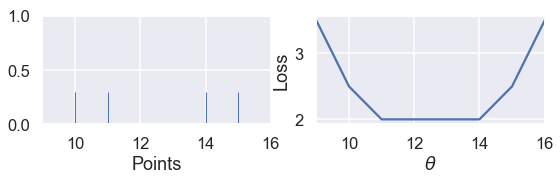

In [17]:
# HIDDEN
points_and_loss(np.array([10, 11, 14, 15]), (9, 16))

This is not the case when we use the MSE:

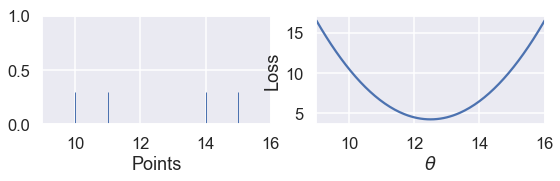

In [18]:
# HIDDEN
points_and_loss(np.array([10, 11, 14, 15]), (9, 16), mse_loss)

### MSE and MAE Comparison

Our investigation and the derivation above show that the MSE is easier to differentiate but is more sensitive to outliers than the MAE. For the MSE, $ \hat{\theta} = \text{mean}(\textbf{y}) $, while for the MAE $ \hat{\theta} = \text{median}(\textbf{y}) $. Notice that the median is less affected by outliers than the mean. This phenomenon arises from our construction of the two loss functions.

We have also seen that the MSE has a unique $ \hat{\theta} $, whereas the mean absolute value can multiple possible $ \hat{\theta} $ values when there are an even number of data points.

### The Huber Loss

A third loss function called the Huber loss combines both the MSE and MAE to create a loss function that is differentiable *and* robust to outliers. The Huber loss accomplishes this by behaving like the MSE function for $\theta$ values close to the minimum and switching to the absolute loss for $\theta$ values far from the minimum.

As usual, we create a loss function by taking the mean of the Huber losses for each point in our dataset.

Let's see what the Huber loss function outputs for a dataset of $ \textbf{y} = [14] $ as we vary $ \theta $:

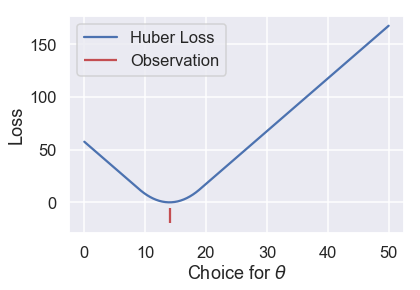

In [19]:
# HIDDEN
def huber_loss(est, y_obs, alpha = 1):
    d = np.abs(est - y_obs)
    return np.where(d < alpha, 
                    (est - y_obs)**2 / 2.0,
                    alpha * (d - alpha / 2.0))

thetas = np.linspace(0, 50, 200)
loss = huber_loss(thetas, np.array([14]), alpha=5)
plt.plot(thetas, loss, label="Huber Loss")
plt.vlines(np.array([14]), -20, -5,colors="r", label="Observation")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend()
plt.savefig('huber_loss.pdf')

We can see that the Huber loss is smooth, unlike the MAE. The Huber loss also increases at a linear rate, unlike the quadratic rate of the mean squared loss.

The Huber loss does have a drawback, however. Notice that it transitions from the MSE to the MAE once $ \theta $ gets far enough from the point. We can tweak this "far enough" to get different loss curves. For example, we can make it transition once $ \theta $ is just one unit away from the observation:

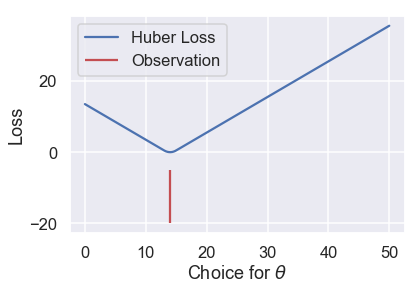

In [20]:
# HIDDEN
loss = huber_loss(thetas, np.array([14]), alpha=1)
plt.plot(thetas, loss, label="Huber Loss")
plt.vlines(np.array([14]), -20, -5,colors="r", label="Observation")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend()
plt.savefig('huber_loss.pdf')

Or we can make it transition when $ \theta $ is ten units away from the observation:

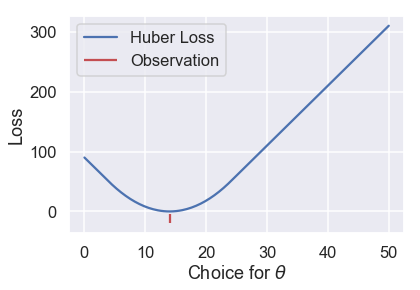

In [21]:
# HIDDEN
loss = huber_loss(thetas, np.array([14]), alpha=10)
plt.plot(thetas, loss, label="Huber Loss")
plt.vlines(np.array([14]), -20, -5,colors="r", label="Observation")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend()
plt.savefig('huber_loss.pdf')

This choice results in a different loss curve and can thus result in different values of $ \hat \theta $. If we want to use the Huber loss function, we have the additional task of setting this transition point to a suitable value.

The Huber loss function is defined mathematically as follows:

$$
L_\alpha(\theta, \textbf{y}) = \frac{1}{n} \sum_{i=1}^n \begin{cases}
    \frac{1}{2}(y_i - \theta)^2 &  | y_i - \theta | \le \alpha \\
    \alpha ( |y_i - \theta| - \frac{1}{2}\alpha ) & \text{otherwise}
\end{cases}
$$

It is more complex than the previous loss functions because it combines both MSE and MAE. The additional parameter $ \alpha $ sets the point where the Huber loss transitions from the MSE to the absolute loss.

Attempting to take the derivative of the Huber loss function is tedious and does not result in an elegant result like the MSE and MAE. Instead, we can use a computational method called gradient descent to find minimizing value of $ \theta $.

### Summary

In this section, we introduce two loss functions: the mean absolute error and the Huber loss functions. We show for a constant model fitted using the MAE, $ \hat{\theta} = \text{median}(\textbf{y}) $.